In [ ]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import DenseNet169
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, auc 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix


In [ ]:
data_path = '/content/drive/MyDrive/CNN Architecture'

In [ ]:
benign_path = os.path.join(data_path, 'begnin','200X')
malignant_path = os.path.join(data_path,'Malignant', '200X')

benign_files = os.listdir(benign_path)
malignant_files = os.listdir(malignant_path)

IMG_SIZE = 224
data = []
labels = []

In [ ]:
n_samples = min(len(benign_files), len(malignant_files))
print(n_samples)

623


In [ ]:
benign_samples = random.sample(benign_files, n_samples)
malignant_samples = random.sample(malignant_files, n_samples)

In [ ]:
for file_name in benign_samples:
  img_path = os.path.join(benign_path, file_name)
  img = cv2.imread(img_path)
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  data.append(img)
  labels.append(0)
for file_name in malignant_samples:
  img_path = os.path.join(malignant_path, file_name)
  img = cv2.imread(img_path)
  img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
  data.append(img)
  labels.append(1)
data = np.array(data)
y= np.array(labels)

In [ ]:
data.shape

(1246, 224, 224, 3)

In [ ]:
X = data.astype('float32')/255.0

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [ ]:
indices = np.arange(len(X_train))
np.random.shuffle(indices)

X_train= X_train[indices]
y_train = y_train[indices]

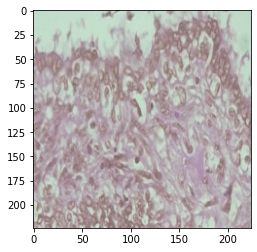

0


In [ ]:
plt.imshow(X_train[39])
plt.show()
print(y_train[39])

# WITH K-FOLD CROSS VALIDATION

In [ ]:
IMG_SIZE = 224
NUM_CLASSES = 1

base_model = DenseNet169(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False
opt = SGD(lr=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])


51877672/51877672 [==============================] - 0s 0us/step


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

for train_index, val_index in kf.split(X):
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [ ]:
model.fit(X_train, y_train, epochs=10, batch_size=32)

Epoch 1/10
32/32 [==============================] - 27s 160ms/step - loss: 0.6186 - accuracy: 0.6730
Epoch 2/10
32/32 [==============================] - 4s 117ms/step - loss: 0.4796 - accuracy: 0.7834
Epoch 3/10
32/32 [==============================] - 4s 122ms/step - loss: 0.4157 - accuracy: 0.8295
Epoch 4/10
32/32 [==============================] - 4s 120ms/step - loss: 0.3898 - accuracy: 0.8385
Epoch 5/10
32/32 [==============================] - 4s 119ms/step - loss: 0.3585 - accuracy: 0.8586
Epoch 6/10
32/32 [==============================] - 4s 123ms/step - loss: 0.3424 - accuracy: 0.8566
Epoch 7/10
32/32 [==============================] - 4s 123ms/step - loss: 0.3209 - accuracy: 0.8746
Epoch 8/10
32/32 [==============================] - 4s 119ms/step - loss: 0.3078 - accuracy: 0.8847
Epoch 9/10
32/32 [==============================] - 4s 121ms/step - loss: 0.2953 - accuracy: 0.8917
Epoch 10/10
32/32 [==============================] - 4s 127ms/step - loss: 0.2815 - accuracy: 0.902

In [ ]:
score = model.evaluate(X_val, y_val, batch_size=32)
print('Validation score:', score[1])
print('Average validation accuracy:', np.mean(score))

8/8 [==============================] - 6s 393ms/step - loss: 0.2802 - accuracy: 0.8956
Validation score: 0.8955823183059692
Average validation accuracy: 0.5879008173942566


<ipython-input-17-46ea0129a9fa>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  y_pred= model.predict_generator(X_test).ravel()


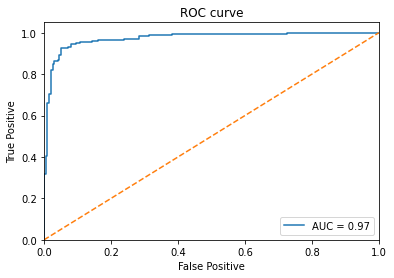

In [ ]:
y_true = y_test
y_pred= model.predict_generator(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
auc_score= roc_auc_score(y_true, y_pred)
plt.plot(fpr,tpr,label='AUC = %0.2f' % auc_score)
plt.plot([0,1], [0,1], linestyle= '--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive')
plt.ylabel('True Positive')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)
accuracy= accuracy_score(y_test, y_pred_classes)
precision= precision_score(y_test, y_pred_classes)
recall= recall_score(y_test, y_pred_classes)
f1= f1_score(y_test, y_pred_classes)
print("Accuracy:" +str(accuracy))
print("Precision:" +str(precision))
print("Recall:" +str(recall))
print("F1_score:" +str(f1))

12/12 [==============================] - 1s 120ms/step
Accuracy:0.9171122994652406
Precision:0.8802083333333334
Recall:0.9548022598870056
F1_score:0.9159891598915988


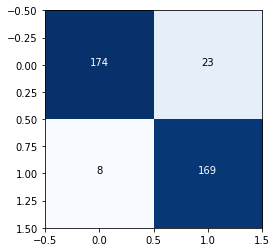

In [ ]:
confusion_matrix = confusion_matrix(y_test,y_pred_classes)
plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
tick_marks = np.arange(2)
thresh = confusion_matrix.max() / 2
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")
plt.show()

# WITHOUT K-FOLD CROSS VALIDATION

In [ ]:
# Without K-fold
IMG_SIZE = 224
NUM_CLASSES = 1

base_model = DenseNet169(input_shape=(IMG_SIZE, IMG_SIZE, 3), include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, batch_size=32, epochs=8, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)

print("Test Accuracy: ", test_acc)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_4 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_4[0][0]']       
                                )                                                           

In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.round(y_pred)

12/12 [==============================] - 6s 121ms/step


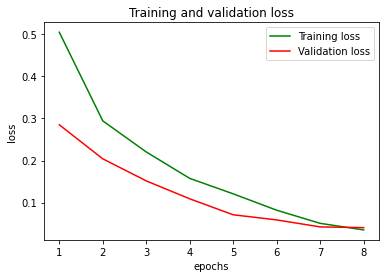

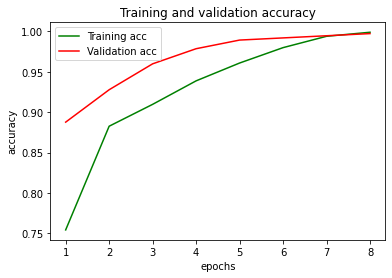

In [ ]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs= range (1, len(loss) +1)
plt.plot(epochs,loss,'g',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

acc=history.history['accuracy']
val_acc= history.history['val_accuracy']
plt.plot(epochs,acc,'g',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes)
recall = recall_score(y_test, y_pred_classes)
f1 = f1_score(y_test, y_pred_classes)
auc = roc_auc_score(y_test, y_pred)

print("Accuracy: " + str(accuracy))
print("Precision: " + str(precision))
print("Recall: " + str(recall))
print("F1: " + str(f1))
print("AUC: "+ str(auc))

Accuracy: 0.9973262032085561
Precision: 0.9943820224719101
Recall: 1.0
F1: 0.9971830985915493
AUC: 1.0


In [ ]:
confusion_mat = confusion_matrix(y_test, y_pred_classes)
from sklearn.metrics import confusion_matrix
plt.imshow(confusion_mat, cmap=plt.cm.Blues)
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Benign", "Malignant"])
plt.yticks(tick_marks, ["Benign", "Malignant"])
thresh = confusion_mat.max() / 2
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, format(confusion_mat[i, j], "d"),
                 horizontalalignment="center",
                 color="white" if confusion_mat[i, j] > thresh else "black")

plt.show()

TypeError: ignored